#### План

1. Задача классификации пассажиров
2. Мы имеем *структурированные* *статические* данные
3. Успех – ?
4. 11 фич, 7 категориальных, 4 числовые
5. Попробую 12 алгоритмов классификации.

#### Загрузка

In [88]:
import numpy as np
import pandas as pd

In [89]:
train = pd.read_csv("passangers.csv")
test = pd.read_csv('titanic_test.csv')

# combine = [df, test_df]

In [90]:
train.head(1)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.25,NaN,S


In [91]:
test.head(1)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q


In [92]:
print(train.shape)
print(test.shape)

(891, 12)
(418, 11)


In [93]:
train['train_test'] = 1 # добавляем признак принадлежности к обучающему набору
test['train_test'] = 0 # тот же самый признак, чтобы можно было вернуться к тем же наборам

test['Survived'] = np.NaN # чтобы мы смогли объединий данные в один датафрейм

data = pd.concat([train, test]) # объединяем фрейм

In [94]:
all_data = pd.concat([train, test])
all_data.shape

(1309, 13)

# Подготовка данных

## ONE. EDA

Мы имеем 891 экземпляр и 11 признаков (1 таргет) на тестовой выборке

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
 12  train_test   891 non-null    int64  
dtypes: float64(2), int64(6), object(5)
memory usage: 90.6+ KB


In [6]:
train.describe(include='O')

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Simonius-Blumer, Col. Oberst Alfons",male,1601,B96 B98,S
freq,1,577,7,4,644


In [7]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,train_test
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000,891.0
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208,1.0
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429,0.0
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000,1.0
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400,1.0
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200,1.0
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000,1.0
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200,1.0


In [8]:
train.describe().columns # просмтотреть численные фичи

Index(['PassengerId', 'Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare',
       'train_test'],
      dtype='object')

In [9]:
train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'train_test'],
      dtype='object')

In [10]:
df_num = train[['Age', 'SibSp', 'Parch', 'Fare']]
df_cat = train[['Survived', 'Pclass', 'Sex', 'Ticket', 'Cabin', 'Embarked']]

In [11]:
print(len(df_num.columns))
print(len(df_cat.columns))

4
6


Посмотрим на числовые и тестовые данные в отдельности.

Для числовых данных:

1. Сделать гистограммы и понять распределения
2. Сделать кореляционные матрицы
3. Создать сводную таблицу сравнивающая выживаемост по числовым переменным


Для категориальных:

1. Сделать бар-графики для погнимания баланса классов
2. Создать сводные талицы для понимания отношения между выживаемостью.

In [12]:
import matplotlib.pyplot as plt

### Числовые

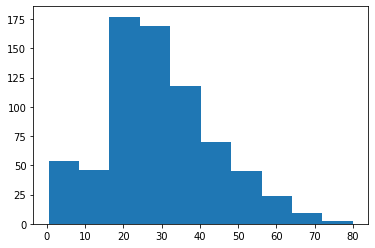

In [13]:
plt.hist(df_num['Age']);

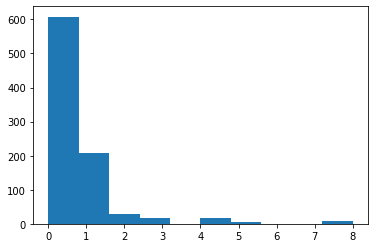

In [14]:
plt.hist(df_num['SibSp']);

#### Гистограммы

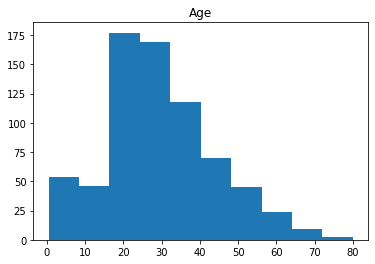

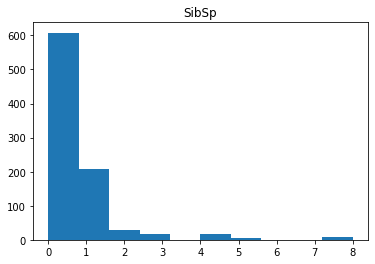

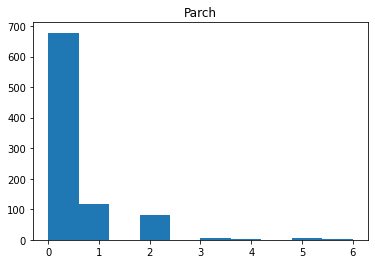

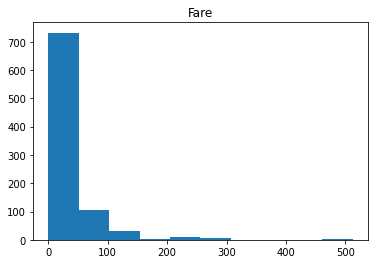

In [15]:
for col in df_num.columns:
  plt.hist(df_num[col])
  plt.title(col)
  plt.show()

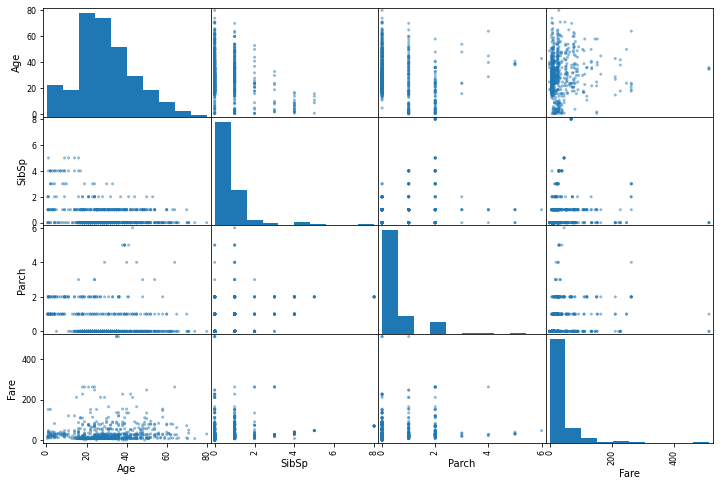

In [16]:
from pandas.plotting import scatter_matrix
scatter_matrix(df_num, figsize=(12,8));

#### Корреляции

In [17]:
corr_matrix_num = df_num.corr()
corr_matrix_num

,Age,SibSp,Parch,Fare
Age,1.000000,-0.308247,-0.189119,0.096067
SibSp,-0.308247,1.000000,0.414838,0.159651
Parch,-0.189119,0.414838,1.000000,0.216225
Fare,0.096067,0.159651,0.216225,1.000000


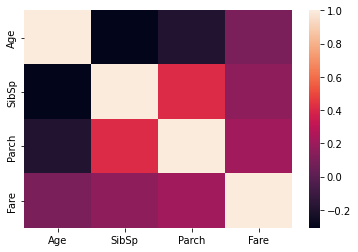

In [18]:
import seaborn as sns

sns.heatmap(corr_matrix_num);

#### Сводная таблица

Оцениваем шанс выжить в зависимости от числового атрибута

In [19]:
# среднее значение атрибута в классе
pd.pivot_table(train, index = 'Survived', values = ['Age','SibSp','Parch','Fare'])

,Age,Fare,Parch,SibSp
Survived,,,,
0,30.626179,22.117887,0.329690,0.553734
1,28.343690,48.395408,0.464912,0.473684


### Категориальные

#### Бар графики

In [20]:
df_cat['Survived'].value_counts().index

Int64Index([0, 1], dtype='int64')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


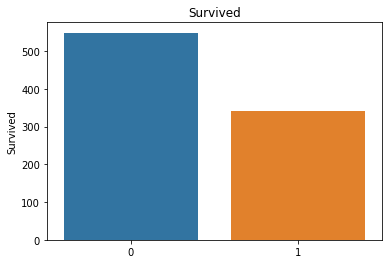

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


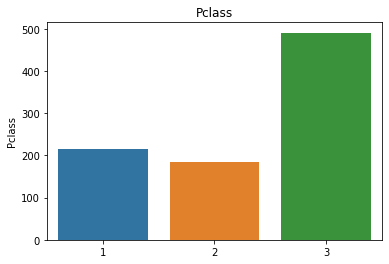

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


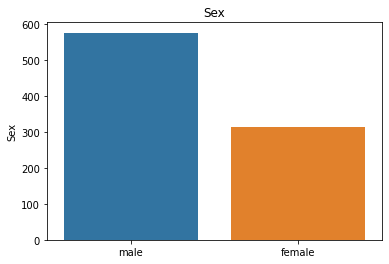

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


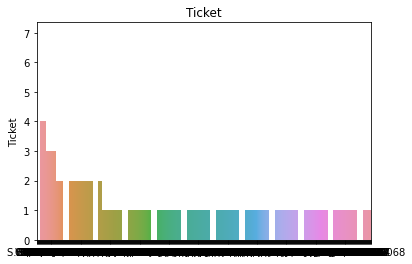

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


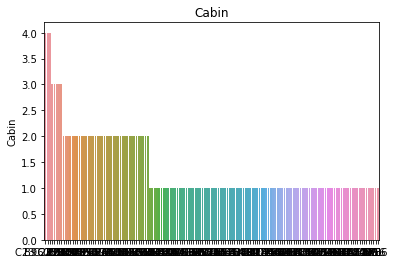

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


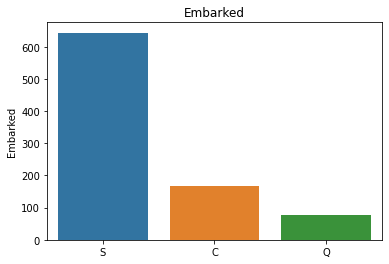

In [21]:
for i in df_cat.columns:
    sns.barplot(df_cat[i].value_counts().index,df_cat[i].value_counts()).set_title(i)
    plt.show()\

У атрибутов Ticket и Cabin очень много различных значений, а значит в чистом виде они не булут нести важной информации.

Мы можем придумать как комбинировать или объединить в классы эти признаки.

#### Сводные таблицы

In [22]:
df_cat.head(3)

,Survived,Pclass,Sex,Ticket,Cabin,Embarked
0,0,3,male,A/5 21171,NaN,S
1,1,1,female,PC 17599,C85,C
2,1,3,female,STON/O2. 3101282,NaN,S


In [23]:
print(pd.pivot_table(train,
                     index = 'Survived',
                     columns = 'Pclass',
                     values = 'Ticket',
                     aggfunc ='count'))

Pclass      1   2    3
Survived              
0          80  97  372
1         136  87  119


In [24]:
print(pd.pivot_table(train, index = 'Survived',
                     columns = 'Sex',
                     values = 'Ticket',
                     aggfunc ='count'))

Sex       female  male
Survived              
0             81   468
1            233   109


In [25]:
print(pd.pivot_table(train, index = 'Survived',
                     columns = 'Embarked',
                     values = 'Ticket',
                     aggfunc ='count'))

Embarked   C   Q    S
Survived             
0         75  47  427
1         93  30  217


Осталось 2 фичи Cabin и Ticket которые очень разнообразные.

## TWO. Препроцессинг


In [95]:
all_data.isna().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
train_test        0
dtype: int64

### 4.Feature engineering

In [27]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
train_test       0
dtype: int64

##### 1.Cabin --> 'Cabin_mul'

1. Крафтим новый признак из 'Cabin' --> 'cabin_multiple', показывающий сколько кают было куплено на одно имя (0-4)

2. заполняем значения "0" там, где были пропуски.

In [28]:
df_cat.Cabin
train['cabin_multiple'] = train.Cabin.apply(lambda x: 0 if pd.isna(x) else len(x.split(' ')))
# добавляет к фрейму 0 если Cabin = Nan, иначе подсчитвывает сколичество Cabin купленных на это имя, спользуя пробел

train['cabin_multiple'].value_counts()

0    687
1    180
2     16
3      6
4      2
Name: cabin_multiple, dtype: int64

In [29]:
pd.pivot_table(train,
               index = 'Survived',
               columns = 'cabin_multiple',
               values = 'Ticket',
               aggfunc ='count')

cabin_multiple,0,1,2,3,4
Survived,,,,,
0,481.0,58.0,7.0,3.0,NaN
1,206.0,122.0,9.0,3.0,2.0


##### 2.Cabin-->'Cabin_adv'

In [30]:
# присваивает значение первого этемента в строке
# нулевые значения – это отдельная катрегория

train['cabin_adv'] = train.Cabin.apply(lambda x: str(x)[0])

In [31]:
print(train.cabin_adv.value_counts())

n    687
C     59
B     47
D     33
E     32
A     15
F     13
G      4
T      1
Name: cabin_adv, dtype: int64


In [32]:
pd.pivot_table(train,index='Survived',columns='cabin_adv', values = 'Name', aggfunc='count')

cabin_adv,A,B,C,D,E,F,G,T,n
Survived,,,,,,,,,
0,8.0,12.0,24.0,8.0,8.0,5.0,2.0,1.0,481.0
1,7.0,35.0,35.0,25.0,24.0,8.0,2.0,NaN,206.0


#####3.Ticket -->'Numeric_ticket'

In [33]:
# Если Ticket числовой, то присваивает класс "0"
train['numeric_ticket'] = train.Ticket.apply(lambda x: 1 if x.isnumeric() else 0)

In [34]:
train['numeric_ticket'].value_counts()

1    661
0    230
Name: numeric_ticket, dtype: int64

#####4.Ticket -->'Ticket_letters'

In [35]:
# Если Ticket не числовой, то удаляет неинформативные символы и применяет метод lower()
train['ticket_letters'] = train.Ticket.apply(lambda x: ''.join(x.split(' ')[:-1]).replace('.','').replace('/','').lower() if len(x.split(' ')[:-1]) >0 else 0)

In [36]:
pd.set_option("max_rows", None) # прокрутка
train['ticket_letters'].value_counts()

0            665
pc            60
ca            41
a5            21
stono2        18
sotonoq       15
scparis       11
wc            10
a4             7
soc            6
c              5
fcc            5
wep            3
sopp           3
pp             3
swpp           2
scah           2
ppp            2
sotono2        2
scow           1
fa             1
sc             1
sca4           1
scahbasle      1
fc             1
sp             1
sop            1
as             1
casoton        1
Name: ticket_letters, dtype: int64



---



---



In [37]:
# разница выживаемости в зависимости типа билета (с буквами и без)
pd.pivot_table(train,
               index='Survived',
               columns='numeric_ticket',
               values = 'Ticket',
               aggfunc='count')

numeric_ticket,0,1
Survived,,
0,142,407
1,88,254


In [38]:
# разница выжеваемости в зависимости от категории билета
pd.pivot_table(train,
               index='Survived',
               columns='ticket_letters',
               values = 'Ticket',
               aggfunc='count')

ticket_letters,0,a4,a5,as,c,ca,casoton,fa,fc,fcc,pc,pp,ppp,sc,sca4,scah,scahbasle,scow,scparis,soc,sop,sopp,sotono2,sotonoq,sp,stono2,swpp,wc,wep
Survived,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,410.0,7.0,19.0,1.0,3.0,27.0,1.0,1.0,1.0,1.0,21.0,1.0,1.0,NaN,1.0,1.0,NaN,1.0,6.0,5.0,1.0,3.0,2.0,13.0,1.0,10.0,NaN,9.0,2.0
1,255.0,NaN,2.0,NaN,2.0,14.0,NaN,NaN,NaN,4.0,39.0,2.0,1.0,1.0,NaN,1.0,1.0,NaN,5.0,1.0,NaN,NaN,NaN,2.0,NaN,8.0,2.0,1.0,1.0




---
Проводим крафт признаков на всем наборе

In [104]:
all_data['cabin_multiple'] = all_data.Cabin.apply(lambda x: 0 if pd.isna(x) else len(x.split(' ')))
all_data['cabin_adv'] = all_data.Cabin.apply(lambda x: str(x)[0])
all_data['numeric_ticket'] = all_data.Ticket.apply(lambda x: 1 if x.isnumeric() else 0)
all_data['ticket_letters'] = all_data.Ticket.apply(lambda x: ''.join(x.split(' ')[:-1]).replace('.','').replace('/','').lower() if len(x.split(' ')[:-1]) >0 else 0)

In [106]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1307 entries, 0 to 417
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   PassengerId     1307 non-null   int64  
 1   Survived        889 non-null    float64
 2   Pclass          1307 non-null   int64  
 3   Name            1307 non-null   object 
 4   Sex             1307 non-null   object 
 5   Age             1307 non-null   float64
 6   SibSp           1307 non-null   int64  
 7   Parch           1307 non-null   int64  
 8   Ticket          1307 non-null   object 
 9   Fare            1307 non-null   float64
 10  Cabin           293 non-null    object 
 11  Embarked        1307 non-null   object 
 12  train_test      1307 non-null   int64  
 13  norm_fare       1307 non-null   float64
 14  cabin_multiple  1307 non-null   int64  
 15  cabin_adv       1307 non-null   object 
 16  numeric_ticket  1307 non-null   int64  
 17  ticket_letters  1307 non-null   ob

In [41]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   PassengerId     1309 non-null   int64  
 1   Survived        891 non-null    float64
 2   Pclass          1309 non-null   int64  
 3   Name            1309 non-null   object 
 4   Sex             1309 non-null   object 
 5   Age             1046 non-null   float64
 6   SibSp           1309 non-null   int64  
 7   Parch           1309 non-null   int64  
 8   Ticket          1309 non-null   object 
 9   Fare            1308 non-null   float64
 10  Cabin           295 non-null    object 
 11  Embarked        1307 non-null   object 
 12  train_test      1309 non-null   int64  
 13  cabin_multiple  1309 non-null   int64  
 14  cabin_adv       1309 non-null   object 
 15  numeric_ticket  1309 non-null   int64  
 16  ticket_letters  1309 non-null   object 
dtypes: float64(3), int64(7), object(7)

### 1.Imputation

In [96]:
# удаление где Embarked = 0 
all_data.dropna(subset=['Embarked'],inplace = True)

In [97]:
# медиана в Age
all_data.Age = all_data.Age.fillna(train.Age.median())

In [98]:
# медиана в Fare
all_data.Fare = all_data.Fare.fillna(train.Fare.median())

In [99]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1307 entries, 0 to 417
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1307 non-null   int64  
 1   Survived     889 non-null    float64
 2   Pclass       1307 non-null   int64  
 3   Name         1307 non-null   object 
 4   Sex          1307 non-null   object 
 5   Age          1307 non-null   float64
 6   SibSp        1307 non-null   int64  
 7   Parch        1307 non-null   int64  
 8   Ticket       1307 non-null   object 
 9   Fare         1307 non-null   float64
 10  Cabin        293 non-null    object 
 11  Embarked     1307 non-null   object 
 12  train_test   1307 non-null   int64  
dtypes: float64(3), int64(5), object(5)
memory usage: 143.0+ KB


### 3.Normalization

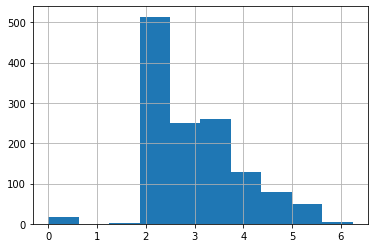

In [100]:
all_data['norm_fare'] = np.log(all_data.Fare+1)
all_data['norm_fare'].hist()

In [101]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1307 entries, 0 to 417
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1307 non-null   int64  
 1   Survived     889 non-null    float64
 2   Pclass       1307 non-null   int64  
 3   Name         1307 non-null   object 
 4   Sex          1307 non-null   object 
 5   Age          1307 non-null   float64
 6   SibSp        1307 non-null   int64  
 7   Parch        1307 non-null   int64  
 8   Ticket       1307 non-null   object 
 9   Fare         1307 non-null   float64
 10  Cabin        293 non-null    object 
 11  Embarked     1307 non-null   object 
 12  train_test   1307 non-null   int64  
 13  norm_fare    1307 non-null   float64
dtypes: float64(4), int64(5), object(5)
memory usage: 153.2+ KB


### 2.Encoding

In [107]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1307 entries, 0 to 417
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   PassengerId     1307 non-null   int64  
 1   Survived        889 non-null    float64
 2   Pclass          1307 non-null   int64  
 3   Name            1307 non-null   object 
 4   Sex             1307 non-null   object 
 5   Age             1307 non-null   float64
 6   SibSp           1307 non-null   int64  
 7   Parch           1307 non-null   int64  
 8   Ticket          1307 non-null   object 
 9   Fare            1307 non-null   float64
 10  Cabin           293 non-null    object 
 11  Embarked        1307 non-null   object 
 12  train_test      1307 non-null   int64  
 13  norm_fare       1307 non-null   float64
 14  cabin_multiple  1307 non-null   int64  
 15  cabin_adv       1307 non-null   object 
 16  numeric_ticket  1307 non-null   int64  
 17  ticket_letters  1307 non-null   ob

In [108]:
all_dummies = pd.get_dummies(all_data[['Pclass','Sex','Age','SibSp','Parch','norm_fare','Embarked','cabin_adv','cabin_multiple','numeric_ticket','train_test']])
all_dummies.head(5)

,Pclass,Age,SibSp,Parch,norm_fare,cabin_multiple,numeric_ticket,train_test,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,cabin_adv_A,cabin_adv_B,cabin_adv_C,cabin_adv_D,cabin_adv_E,cabin_adv_F,cabin_adv_G,cabin_adv_T,cabin_adv_n
0,3,22.0,1,0,2.110213,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,1
1,1,38.0,1,0,4.280593,1,0,1,1,0,1,0,0,0,0,1,0,0,0,0,0,0
2,3,26.0,0,0,2.188856,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,1
3,1,35.0,1,0,3.990834,1,1,1,1,0,0,0,1,0,0,1,0,0,0,0,0,0
4,3,35.0,0,0,2.202765,0,1,1,0,1,0,0,1,0,0,0,0,0,0,0,0,1


In [109]:
all_dummies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1307 entries, 0 to 417
Data columns (total 22 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Pclass          1307 non-null   int64  
 1   Age             1307 non-null   float64
 2   SibSp           1307 non-null   int64  
 3   Parch           1307 non-null   int64  
 4   norm_fare       1307 non-null   float64
 5   cabin_multiple  1307 non-null   int64  
 6   numeric_ticket  1307 non-null   int64  
 7   train_test      1307 non-null   int64  
 8   Sex_female      1307 non-null   uint8  
 9   Sex_male        1307 non-null   uint8  
 10  Embarked_C      1307 non-null   uint8  
 11  Embarked_Q      1307 non-null   uint8  
 12  Embarked_S      1307 non-null   uint8  
 13  cabin_adv_A     1307 non-null   uint8  
 14  cabin_adv_B     1307 non-null   uint8  
 15  cabin_adv_C     1307 non-null   uint8  
 16  cabin_adv_D     1307 non-null   uint8  
 17  cabin_adv_E     1307 non-null   ui

### 5.Selection (optional)

Will be added

### 6.Imbalances (optional)

Just for save strucrure

## THREE. Разделение

In [49]:
X_train = all_dummies[all_dummies.train_test == 1].drop(['train_test'], axis =1)
X_test = all_dummies[all_dummies.train_test == 0].drop(['train_test'], axis =1)

In [50]:
print(X_train.shape)
print(X_test.shape)

(889, 21)
(418, 21)


In [51]:
y_train = all_data[all_data.train_test==1].Survived

In [52]:
print(y_train.shape)

(889,)


### Scaled

In [53]:
from sklearn.preprocessing import StandardScaler

scale = StandardScaler()
all_dummies_scaled = all_dummies.copy()

all_dummies_scaled[['Age','SibSp','Parch','norm_fare']]= scale.fit_transform(all_dummies_scaled[['Age','SibSp','Parch','norm_fare']])
all_dummies_scaled.head(5)

,Pclass,Age,SibSp,Parch,norm_fare,cabin_multiple,numeric_ticket,train_test,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,cabin_adv_A,cabin_adv_B,cabin_adv_C,cabin_adv_D,cabin_adv_E,cabin_adv_F,cabin_adv_G,cabin_adv_T,cabin_adv_n
0,3,-0.580261,0.480272,-0.445407,-0.896331,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,1
1,1,0.662297,0.480272,-0.445407,1.347870,1,0,1,1,0,1,0,0,0,0,1,0,0,0,0,0,0
2,3,-0.269621,-0.479537,-0.445407,-0.815013,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,1
3,1,0.429318,0.480272,-0.445407,1.048255,1,1,1,1,0,0,0,1,0,0,1,0,0,0,0,0,0
4,3,0.429318,-0.479537,-0.445407,-0.800632,0,1,1,0,1,0,0,1,0,0,0,0,0,0,0,0,1


In [54]:
X_train_scaled = all_dummies_scaled[all_dummies_scaled.train_test == 1].drop(['train_test'], axis =1)
X_test_scaled = all_dummies_scaled[all_dummies_scaled.train_test == 0].drop(['train_test'], axis =1)

y_train = all_data[all_data.train_test==1].Survived

In [79]:
y_train.head(1)

0    0.0
Name: Survived, dtype: float64

In [77]:
print(X_train_scaled.shape)
print(X_test_scaled.shape)
print(y_train.shape)

(889, 21)
(418, 21)
(889,)


In [55]:
X_test_scaled.shape

(418, 21)

# Обучение и оценка моделей

In [56]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [57]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

## LogisticRegression

In [58]:
lr = LogisticRegression(max_iter = 2000)
cv = cross_val_score(lr,X_train_scaled,y_train,cv=5)
print(cv)
print(cv)
log_acc = cv.mean()
print(log_acc)

[0.78089888 0.80898876 0.76404494 0.79213483 0.81355932]
[0.78089888 0.80898876 0.76404494 0.79213483 0.81355932]
0.791925347552847


## GaussianNB

In [59]:
gnb = GaussianNB()
cv = cross_val_score(gnb,X_train_scaled,y_train,cv=5)
print(cv)
print(cv.mean())

[0.69101124 0.67977528 0.70786517 0.73033708 0.76271186]
0.7143401256903447


## DecisionTreeClassifier

In [60]:
dt = DecisionTreeClassifier(random_state = 1)
cv = cross_val_score(dt,X_train_scaled,y_train,cv=5)
print(cv)
print(cv.mean())

[0.74719101 0.75842697 0.83146067 0.75280899 0.81355932]
0.7806893924966674


## SVM

### LinearSVC

In [61]:
svcl = LinearSVC()
cv = cross_val_score(svcl,X_train_scaled,y_train,cv=5)
print(cv)
print(cv.mean())

[0.78089888 0.81460674 0.7752809  0.76966292 0.81355932]
0.7908017520472291


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


### SVC

In [62]:
svc = SVC(probability = True)
cv = cross_val_score(svc,X_train_scaled,y_train,cv=5)
print(cv)
print(cv.mean())

[0.8258427  0.82022472 0.80898876 0.80337079 0.83615819]
0.8189170316765061


## KNeighborsClassifier

In [63]:
knn = KNeighborsClassifier()
cv = cross_val_score(knn,X_train_scaled,y_train,cv=5)
print(cv)
print(cv.mean())

[0.76404494 0.78089888 0.78651685 0.79213483 0.81920904]
0.7885609090332




---


## XGBoost

In [64]:
from xgboost import XGBClassifier
xgb = XGBClassifier(random_state =1)
cv = cross_val_score(xgb,X_train_scaled,y_train,cv=5)
print(cv)
print(cv.mean())

[0.79213483 0.82022472 0.84831461 0.78089888 0.86440678]
0.8211959626737764


## GradientBoostClassifier

In [65]:
from sklearn.ensemble import GradientBoostingClassifier

dbc = GradientBoostingClassifier()
cv = cross_val_score(dbc, X_train_scaled, y_train, cv=5)
print(cv)
print(cv.mean())

[0.80898876 0.81460674 0.85955056 0.79213483 0.86440678]
0.8279375357074844


## AdaBoost

In [66]:
from sklearn.ensemble import AdaBoostClassifier

ada = GradientBoostingClassifier()
cv = cross_val_score(ada, X_train_scaled, y_train, cv=5)
print(cv)
print(cv.mean())

[0.80898876 0.81460674 0.85955056 0.79213483 0.86440678]
0.8279375357074844


## CatBoost

Will be added

## BaggingClassifier

In [67]:
from sklearn.ensemble import BaggingClassifier

bgc = GradientBoostingClassifier()
cv = cross_val_score(bgc, X_train_scaled, y_train, cv=5)
print(cv)
bagg_acc = cv.mean()
print(bagg_acc)

[0.80898876 0.81460674 0.85955056 0.79213483 0.86440678]
0.8279375357074844


In [68]:
bgc.fit(X_train_scaled, y_train)
Y_pred = bgc.predict(X_test_scaled)

In [69]:
Y_pred[:15]

array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1.])

## RandomForestClassifier

In [70]:
rf = RandomForestClassifier(random_state = 1)
cv = cross_val_score(rf,X_train_scaled,y_train,cv=5)
print(cv)
rf_acc = cv.mean()
print(rf_acc)

[0.7752809  0.79213483 0.83146067 0.74719101 0.83050847]
0.7953151780613218


## ExtraTreesClassifier

In [71]:
from sklearn.ensemble import ExtraTreesClassifier

ext = RandomForestClassifier(random_state = 1)
cv = cross_val_score(ext,X_train_scaled,y_train,cv=5)
print(cv)
ext_acc = cv.mean()
print(ext_acc)

[0.7752809  0.79213483 0.83146067 0.74719101 0.83050847]
0.7953151780613218


# All models

In [72]:
# словарь для сохранения результатов моделей
'''models = pd.DataFrame({
    'Model': ['Support Vector Machines', 'KNN', 'Logistic Regression', 
              'Random Forest', 'Naive Bayes', 'Perceptron', 
              'Stochastic Gradient Decent', 'Linear SVC', 
              'Decision Tree'],
    'Score': [acc_svc, acc_knn, acc_log, 
              acc_random_forest, acc_gaussian, acc_perceptron, 
              acc_sgd, acc_linear_svc, acc_decision_tree]})'''


models = pd.DataFrame({
    'Model': ['Logistic Regression', 'Extratrees', 'RandomForest', 'BaggingClf'],
    'Score': [log_acc, ext_acc, rf_acc, bagg_acc]
})

models

,Model,Score
0,Logistic Regression,0.791925
1,Extratrees,0.795315
2,RandomForest,0.795315
3,BaggingClf,0.827938


In [73]:
submission = pd.DataFrame({
        "PassengerId": test["PassengerId"],
        "Survived": Y_pred
    })

In [74]:
submission.to_csv('submission.csv', index=False)

## Decision Tree

### fit model

In [153]:
from sklearn.model_selection import train_test_split

X_train2, X_test2, y_train2, y_test2 = train_test_split(X_train_scaled, y_train,
                                                    test_size=0.33,
                                                    random_state=42)

In [154]:
print(X_train2.shape)
print(y_train2.shape)
print(X_test2.shape)
print(y_test2.shape)

(595, 21)
(595,)
(294, 21)
(294,)


In [155]:
from sklearn.tree import DecisionTreeClassifier
 
dt2 = DecisionTreeClassifier()
dt2.fit(X_train2, y_train2)
predictions = dt2.predict(X_test2)

### random instance

In [156]:
pd.options.display.max_rows = 10

In [157]:
X_test2.head(5)

,Pclass,Age,SibSp,Parch,norm_fare,cabin_multiple,numeric_ticket,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,cabin_adv_A,cabin_adv_B,cabin_adv_C,cabin_adv_D,cabin_adv_E,cabin_adv_F,cabin_adv_G,cabin_adv_T,cabin_adv_n
281,3,-0.114301,-0.479537,-0.445407,-0.823249,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,1
435,1,-1.201540,0.480272,1.864701,1.880591,2,1,1,0,0,0,1,0,1,0,0,0,0,0,0,0
39,3,-1.201540,0.480272,-0.445407,-0.488274,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,1
418,2,0.041018,-0.479537,-0.445407,-0.349500,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,1
585,1,-0.890900,-0.479537,1.864701,1.461121,1,1,1,0,0,0,1,0,0,0,0,1,0,0,0,0


In [158]:
some_instanse = np.array(X_test2.loc[418])
some_instanse = some_instanse.reshape(1,-1) 

In [159]:
dt.predict(some_instanse)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  "X does not have valid feature names, but"


array([0.])

In [160]:
y_test2.loc[418]

0.0

### accuracy 

In [161]:
print(X_test2.shape)
print(y_test2.shape)

(294, 21)
(294,)


In [162]:
# score on test
dt2.score(X_test2, y_test2)

0.7585034013605442

In [173]:
# score on test 2
from sklearn.metrics import accuracy_score

accuracy_score(y_test2, predictions)

0.7585034013605442

### cross-val score

In [172]:
# cross_val_score
from sklearn.model_selection import cross_val_score

cv = cross_val_score(dt2, X_train2, y_train2, cv=3)
print("cv_accuracy:", cv ,"\n")
print("mean_accuracy:", cv.mean())

cv_accuracy: [0.76884422 0.8030303  0.78787879] 

mean_accuracy: 0.786584437338206


In [175]:
# cross val predict, clean prediction
from sklearn.model_selection import cross_val_predict

cross_val_pred = cross_val_predict(dt, X_train2, y_train2)

### confusion matrix, precision, recall, f1

In [176]:
# confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train2, cross_val_pred)

array([[298,  67],
       [ 64, 166]])

In [215]:
import seaborn as sns

sns.set(font_scale=1.5) # размер шрифта

In [219]:
def plot_conf_mat(y_test, y_preds):
  fig, ax = plt.subplots(figsize=(4,4))
  ax = sns.heatmap(confusion_matrix(y_test, y_preds),
                   annot=True,
                   cbar=False,
                   fmt='.3g')
  plt.xlabel("true label")
  plt.ylabel("predicted label")

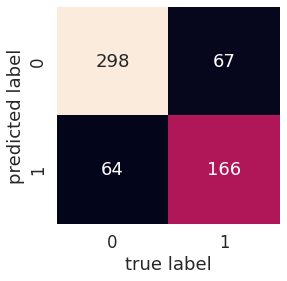

In [220]:
plot_conf_mat(y_train2, cross_val_pred)

In [181]:
# precision, recall, f1

from sklearn.metrics import precision_score, recall_score, f1_score

print(precision_score(y_train2, cross_val_pred))
print(recall_score(y_train2, cross_val_pred))
print(f1_score(y_train2, cross_val_pred))

0.7124463519313304
0.7217391304347827
0.717062634989201


In [221]:
from sklearn.metrics import classification_report

print(classification_report(y_train2, cross_val_pred))

              precision    recall  f1-score   support

         0.0       0.82      0.82      0.82       365
         1.0       0.71      0.72      0.72       230

    accuracy                           0.78       595
   macro avg       0.77      0.77      0.77       595
weighted avg       0.78      0.78      0.78       595



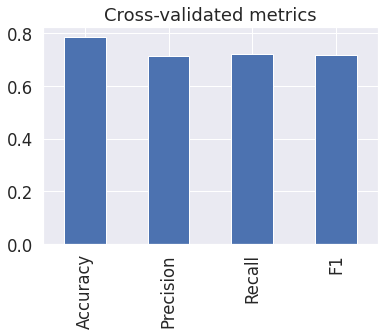

In [222]:
cv_metrics = pd.DataFrame({"Accuracy": cv.mean(),
                           "Precision": precision_score(y_train2, cross_val_pred),
                           "Recall": recall_score(y_train2, cross_val_pred),
                           "F1": f1_score(y_train2, cross_val_pred)},
                          index=[0])
cv_metrics.T.plot.bar(title="Cross-validated metrics",
                      legend=False);

### ROC/AUC

In [194]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve

y_probas_dt = cross_val_predict(dt, X_train2, y_train2, cv=3, method='predict_proba')

In [189]:
y_probas_dt

array([[1., 0.],
       [0., 1.],
       [0., 1.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]])

In [200]:
y_scores_dt = y_probas_dt[:, 1]
fpr_dt, tpr_dt, thresholds_dt = roc_curve(y_train2, y_scores_dt)

In [197]:
def plot_roc_curve(fpr, tpr, label=None):
  plt.plot(fpr, tpr, linewidth=2, label=label)
  plt.plot([0, 1], [0, 1], 'k--')
  plt.axis([0, 1, 0, 1])
  plt.xlabel("FPR", fontsize=16)
  plt.ylabel("TPR (Полнота)", fontsize=16)

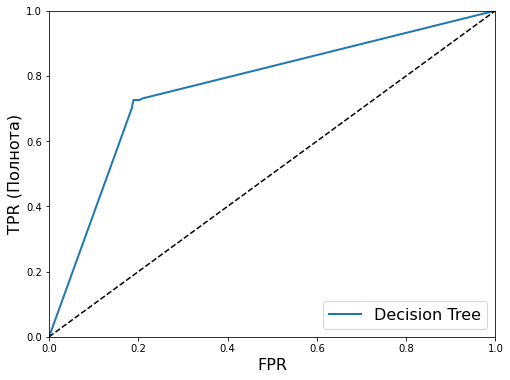

In [201]:
plt.figure(figsize=(8, 6))
plot_roc_curve(fpr_dt, tpr_dt, "Decision Tree")
plt.legend(loc="lower right", fontsize=16)
plt.show()

In [204]:
# auc
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train2, y_scores_dt)

0.7665753424657533

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


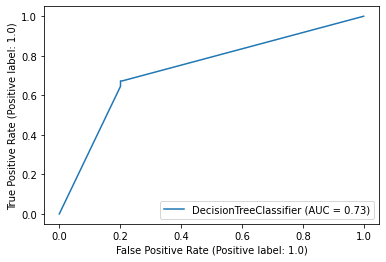

In [209]:
# roc/auc ordinary
from sklearn.metrics import plot_roc_curve

plot_roc_curve(dt, X_test2, y_test2);

# Тюнинг

In [75]:
from sklearn.model_selection import GridSearchCV 
from sklearn.model_selection import RandomizedSearchCV 